## Descargando mapa y data:

In [51]:
import geopandas as gpd

link="https://github.com/chorrillos/preprocesamiento/raw/main/distritos/DistritosMap.zip"
selecDisMap=gpd.read_file(link)

In [52]:
import pandas as pd
link2="https://github.com/chorrillos/spatial/raw/main/consolidado.variables.seleccionadas.xlsx"
datadis=pd.read_excel(link2)

## Corrigiendo texto clave

In [53]:
selecDisMap[selecDisMap.DISTRITO.str.contains('OCTUBRE')]

,DEPARTAMEN,PROVINCIA,DISTRITO,INSTITUCIO,geometry
1800,PIURA,PIURA,VEINTISEIS DE OCTUBRE,IGN,"POLYGON ((-80.65416 -5.17733, -80.64678 -5.182..."


In [54]:
datadis[datadis.Distrito.str.contains('OCTUBRE')]

,Ubigeo,DEPARTAMENTO,PROVINCIA,Distrito,Zona,Latitud,Longitud,cobertura.cell,no.cobertura.cell,Educ.sec.comp,Educ.sec.no.comp,esp.vid.nacer,Ing.fam.p.cap,NBI.2017,NBI.2017.c,Pobreza,No.Pobreza
1557,200115,PIURA,PIURA,26 DE OCTUBRE,X,-5.1847,-80.6703,100.0,0.0,72.268115,27.731885,78.407939,976.316983,32.9,67.1,16.25051,83.74949


In [55]:
datadis.loc[datadis.Distrito.str.contains('OCTUBRE'),'Distrito']="VEINTISEIS DE OCTUBRE"

## Normalizando texto

In [56]:
#todo mayuscula sin blanco delante ni cola 

datadis[['PROVINCIA','Distrito']]=datadis[['PROVINCIA','Distrito']].apply(lambda x: x.str.upper().str.strip())
selecDisMap[['PROVINCIA','DISTRITO']]=selecDisMap[['PROVINCIA','DISTRITO']].apply(lambda x: x.str.upper().str.strip())


# concatenando
datadis['provDist']=["+".join(pd) for pd in zip (datadis.PROVINCIA,datadis.Distrito)]
selecDisMap['provDist']=["+".join(pd) for pd in zip (selecDisMap.PROVINCIA,selecDisMap.DISTRITO)]


# eliminando simbolos 
import unidecode
datadis.provDist=[unidecode.unidecode(dist) for dist in datadis.provDist]
selecDisMap.provDist=[unidecode.unidecode(dist) for dist in selecDisMap.provDist]

# reemplazando guiones y espacios multiples por espacio simple
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
selecDisMap.provDist=selecDisMap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

## Detectando diferencias

In [57]:
# valores sin match
sinmatchDATA=list(set(datadis.provDist)- set(selecDisMap.provDist))
sinmatchMAP=list(set(selecDisMap.provDist)-set(datadis.provDist) )

In [58]:
len(sinmatchDATA), len(sinmatchMAP)

(13, 13)

## Buscando matches:

In [59]:
from thefuzz import process
[(dis,process.extractOne(dis,sinmatchMAP)) for dis in sorted(sinmatchDATA)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('ATALAYA+RAIMONDI', ('ATALAYA+RAYMONDI', 94)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('CALLAO+CARMEN DE LA LEGUA', ('CALLAO+CARMEN DE LA LEGUA REYNOSO', 95)),
 ('CHUPACA+SAN JUAN DE ISCOS', ('CHUPACA+SAN JUAN DE YSCOS', 96)),
 ('GRAN CHIMU+COMPIN', ('GRAN CHIMU+MARMOT', 71)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('MAYNAS+PUTUMAYO', ('PUTUMAYO+PUTUMAYO', 95)),
 ('MAYNAS+ROSA PANDURO', ('PUTUMAYO+ROSA PANDURO', 80)),
 ('MAYNAS+TENIENTE MANUEL CLAVERO', ('PUTUMAYO+TENIENTE MANUEL CLAVERO', 87)),
 ('MAYNAS+YAGUAS', ('PUTUMAYO+YAGUAS', 71)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

In [60]:
# dict de cambios:
cambiosDataDis={dis:process.extractOne(dis,sinmatchMAP)[0] for dis in sorted(sinmatchDATA)}
cambiosDataDis

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'ATALAYA+RAIMONDI': 'ATALAYA+RAYMONDI',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'CALLAO+CARMEN DE LA LEGUA': 'CALLAO+CARMEN DE LA LEGUA REYNOSO',
 'CHUPACA+SAN JUAN DE ISCOS': 'CHUPACA+SAN JUAN DE YSCOS',
 'GRAN CHIMU+COMPIN': 'GRAN CHIMU+MARMOT',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'MAYNAS+PUTUMAYO': 'PUTUMAYO+PUTUMAYO',
 'MAYNAS+ROSA PANDURO': 'PUTUMAYO+ROSA PANDURO',
 'MAYNAS+TENIENTE MANUEL CLAVERO': 'PUTUMAYO+TENIENTE MANUEL CLAVERO',
 'MAYNAS+YAGUAS': 'PUTUMAYO+YAGUAS',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [61]:
# ejecutando cambios - "datadis" está OK!
datadis.provDist.replace(cambiosDataDis,inplace=True)

## Preparando mapa

In [62]:
# merge hacia MAPA
selecDisMap=selecDisMap.merge(datadis, on='provDist')

In [63]:
selecDisMap.columns

Index(['DEPARTAMEN', 'PROVINCIA_x', 'DISTRITO', 'INSTITUCIO', 'geometry',
       'provDist', 'Ubigeo', 'DEPARTAMENTO', 'PROVINCIA_y', 'Distrito', 'Zona',
       'Latitud', 'Longitud', 'cobertura.cell', 'no.cobertura.cell',
       'Educ.sec.comp', 'Educ.sec.no.comp', 'esp.vid.nacer', 'Ing.fam.p.cap',
       'NBI.2017', 'NBI.2017.c', 'Pobreza', 'No.Pobreza'],
      dtype='object')

In [64]:
# columnas que se sacan
sacar=['Ubigeo', 'DEPARTAMEN', 'PROVINCIA_x','INSTITUCIO', 'Distrito']
selecDisMap.drop(sacar,axis=1,inplace=True)

In [65]:
# columnas a renombrar
selecDisMap.rename(columns={'PROVINCIA_y':"PROVINCIA"},inplace=True)

In [66]:
# actual
selecDisMap.columns

Index(['DISTRITO', 'geometry', 'provDist', 'DEPARTAMENTO', 'PROVINCIA', 'Zona',
       'Latitud', 'Longitud', 'cobertura.cell', 'no.cobertura.cell',
       'Educ.sec.comp', 'Educ.sec.no.comp', 'esp.vid.nacer', 'Ing.fam.p.cap',
       'NBI.2017', 'NBI.2017.c', 'Pobreza', 'No.Pobreza'],
      dtype='object')

In [67]:
# sin puntos en nombre de archivo
selecDisMap.columns=selecDisMap.columns.str.replace(".","_",regex=False)

In [68]:
selecDisMap.columns

Index(['DISTRITO', 'geometry', 'provDist', 'DEPARTAMENTO', 'PROVINCIA', 'Zona',
       'Latitud', 'Longitud', 'cobertura_cell', 'no_cobertura_cell',
       'Educ_sec_comp', 'Educ_sec_no_comp', 'esp_vid_nacer', 'Ing_fam_p_cap',
       'NBI_2017', 'NBI_2017_c', 'Pobreza', 'No_Pobreza'],
      dtype='object')

In [69]:
selecDisMap

,DISTRITO,geometry,provDist,DEPARTAMENTO,PROVINCIA,Zona,Latitud,Longitud,cobertura_cell,no_cobertura_cell,Educ_sec_comp,Educ_sec_no_comp,esp_vid_nacer,Ing_fam_p_cap,NBI_2017,NBI_2017_c,Pobreza,No_Pobreza
0,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",TACNA+CORONEL GREGORIO ALBARRACIN LANCHIPA,TACNA,TACNA,X,-18.0408,-70.2542,47.058824,52.941176,71.178389,28.821611,77.073616,892.303097,15.8,84.2,18.736677,81.263323
1,POCOLLAY,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...",TACNA+POCOLLAY,TACNA,TACNA,X,-17.9964,-70.2197,64.705882,35.294118,75.825743,24.174257,77.267808,1152.606145,16.1,83.9,13.404542,86.595458
2,CALANA,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...",TACNA+CALANA,TACNA,TACNA,X,-17.9406,-70.1825,59.574468,40.425532,77.829717,22.170283,75.922728,832.802135,15.9,84.1,7.304348,92.695652
3,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",TACNA+TACNA,TACNA,TACNA,X,-18.0100,-70.2478,33.333333,66.666667,75.491958,24.508042,76.670661,1371.819928,7.4,92.6,7.691274,92.308726
4,SAMA,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...",TACNA+SAMA,TACNA,TACNA,X,-17.8586,-70.5731,61.111111,38.888889,70.500250,29.499750,74.249879,897.568256,52.4,47.6,10.643201,89.356799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,CIENEGUILLA,"POLYGON ((-76.72917 -11.99948, -76.72596 -11.9...",LIMA+CIENEGUILLA,LIMA,LIMA,ZNG,-12.1178,-76.8125,100.000000,0.000000,69.643266,30.356734,77.288096,1265.041999,24.7,75.3,17.529394,82.470606
1870,ANCON,"POLYGON ((-77.06501 -11.57523, -77.06499 -11.5...",LIMA+ANCON,LIMA,LIMA,ZNG,-11.7764,-77.1703,100.000000,0.000000,72.117976,27.882024,77.659716,1392.956247,21.7,78.3,19.246935,80.753065
1871,CARABAYLLO,"POLYGON ((-76.89892 -11.72963, -76.89768 -11.7...",LIMA+CARABAYLLO,LIMA,LIMA,ZNG,-11.8583,-77.0419,82.500000,17.500000,74.114567,25.885433,78.849674,1246.479589,20.0,80.0,19.176021,80.823979
1872,MI PERU,"POLYGON ((-77.11491 -11.84189, -77.11450 -11.8...",CALLAO+MI PERU,CALLAO,CALLAO,X,-11.8550,-77.1250,100.000000,0.000000,67.812626,32.187374,81.186620,1241.061299,17.1,82.9,23.941494,76.058506


## Analisis de variables

In [70]:
cols1=['cobertura_cell', 'Educ_sec_comp', 'esp_vid_nacer',
             'Ing_fam_p_cap','NBI_2017_c','No_Pobreza']
selecDisMap[cols1].describe()

,cobertura_cell,Educ_sec_comp,esp_vid_nacer,Ing_fam_p_cap,NBI_2017_c,No_Pobreza
count,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,45.401419,55.769523,73.680183,588.785567,61.406670,65.857929
std,30.515564,15.728123,5.229458,365.103757,18.297153,16.904808
min,0.000000,11.974433,50.557694,51.073334,0.600000,18.738329
25%,18.589216,44.466678,70.729725,306.545767,50.725000,53.234158
50%,42.105263,57.164771,74.038561,499.073047,64.700000,65.700570
75%,70.370370,68.202230,77.432747,804.306417,75.100000,79.092820
max,100.000000,91.744878,85.000000,2037.326546,98.900000,99.942654


<AxesSubplot:>

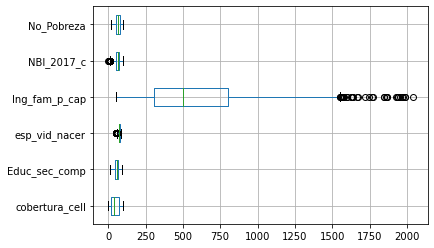

In [71]:
selecDisMap[cols1].boxplot(vert=False)

## Ajuste de rangos

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))
selecDisMap['Ing_fam_p_cap_N']=scaler.fit_transform(selecDisMap['Ing_fam_p_cap'].values.reshape(-1,1))


In [73]:
cols2=['cobertura_cell', 'Educ_sec_comp', 'esp_vid_nacer',
             'Ing_fam_p_cap_N','NBI_2017_c','No_Pobreza']

selecDisMap[cols2].describe()

,cobertura_cell,Educ_sec_comp,esp_vid_nacer,Ing_fam_p_cap_N,NBI_2017_c,No_Pobreza
count,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,45.401419,55.769523,73.680183,27.071686,61.406670,65.857929
std,30.515564,15.728123,5.229458,18.381531,18.297153,16.904808
min,0.000000,11.974433,50.557694,0.000000,0.600000,18.738329
25%,18.589216,44.466678,70.729725,12.862027,50.725000,53.234158
50%,42.105263,57.164771,74.038561,22.555015,64.700000,65.700570
75%,70.370370,68.202230,77.432747,37.922309,75.100000,79.092820
max,100.000000,91.744878,85.000000,100.000000,98.900000,99.942654


array([[<AxesSubplot:title={'center':'cobertura_cell'}>,
        <AxesSubplot:title={'center':'Educ_sec_comp'}>],
       [<AxesSubplot:title={'center':'esp_vid_nacer'}>,
        <AxesSubplot:title={'center':'Ing_fam_p_cap_N'}>],
       [<AxesSubplot:title={'center':'NBI_2017_c'}>,
        <AxesSubplot:title={'center':'No_Pobreza'}>]], dtype=object)

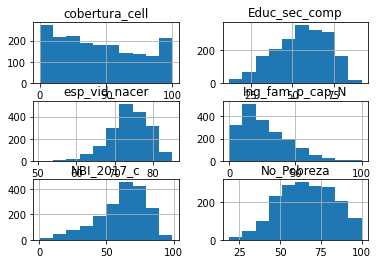

In [74]:
selecDisMap[cols2].hist()

In [75]:
# normalidad
from scipy import stats

k2, p = stats.normaltest(selecDisMap[cols2])
pd.Series(p)

0    2.422144e-173
1     5.739743e-21
2     1.110456e-24
3     2.778930e-59
4     1.602844e-33
5     1.806918e-18
dtype: float64

## Analisis Espacial de "spots"

In [76]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights

## Coropletico:

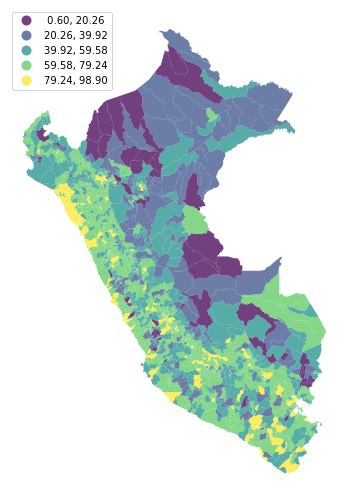

In [77]:
f, ax = plt.subplots(1, figsize=(9, 9))
selecDisMap.plot(column='NBI_2017_c', 
        cmap='viridis', 
        scheme='equal_interval',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

### Cómo saber si un distrito tiene algun parecido a sus vecinos?

In [78]:
#wQ = weights.contiguity.Queen.from_dataframe(selecDisMap)
wKNN=weights.distance.KNN.from_dataframe(selecDisMap, k=8)

In [79]:
# vecindad será valor entre 0 y 1
wKNN.transform = 'R'

In [80]:
# hay islas?
wKNN.islands

[]

In [81]:
# El lag: como se comporta variable en sus vecinos
selecDisMap['w_NBI_2017_c'] = weights.spatial_lag.lag_spatial(wKNN, selecDisMap['NBI_2017_c'])

In [82]:
# standarizando  x y lagx
zscore = lambda x : (x-x.mean())/x.std()
selecDisMap[['z_NBI_2017_c','z_w_NBI_2017_c']]=selecDisMap[['NBI_2017_c','w_NBI_2017_c']].apply(zscore)

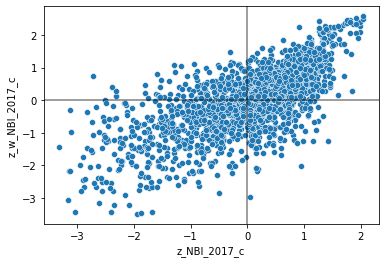

In [83]:
# x y xlag , por cuadrantes
seaborn.scatterplot(data=selecDisMap, x='z_NBI_2017_c', y='z_w_NBI_2017_c')
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

### Coeficiente de correlación para cada distrito con significancia estadística?

In [84]:
lisaNBI = esda.moran.Moran_Local(y=selecDisMap['NBI_2017_c'],
                                 w=wKNN,
                                permutations=1000,
                                seed=123)

# guardando coeficiente de cada distrito
selecDisMap['lisaNBI'] = lisaNBI.Is

<AxesSubplot:xlabel='lisaNBI', ylabel='Density'>

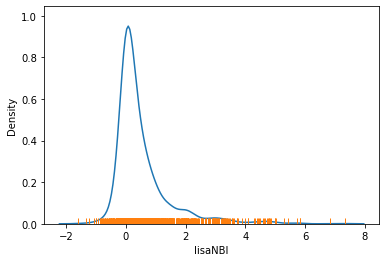

In [85]:
# como está el LISA:
ax = seaborn.kdeplot(selecDisMap['lisaNBI'])
seaborn.rugplot(selecDisMap['lisaNBI'], ax=ax)

### LISA por cuadrante

In [86]:
# tipo de spots: HH=1, LH=2, LL=3, HL=4
pd.Series(lisaNBI.q).value_counts()

1    854
3    565
4    239
2    216
dtype: int64

In [87]:
# guardando cuadrante:
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisaNBI.q]
selecDisMap=selecDisMap.assign(CuadrantesNBI=labels)
selecDisMap[['CuadrantesNBI']]

,CuadrantesNBI
0,Q1
1,Q1
2,Q1
3,Q1
4,Q2
...,...
1869,Q1
1870,Q1
1871,Q1
1872,Q1


In [88]:
# cuales son sig?
lisaNBI.p_sim

array([0.01898102, 0.000999  , 0.000999  , ..., 0.001998  , 0.000999  ,
       0.000999  ])

<AxesSubplot:ylabel='Count'>

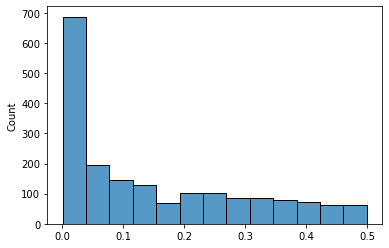

In [89]:
seaborn.histplot(lisaNBI.p_sim)

In [90]:
# guardando LISAs significativos
lisaSigNBI = 1 * (lisaNBI.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaSigNBI]
selecDisMap=selecDisMap.assign(SigNBI=labels)
selecDisMap[['SigNBI']]

,SigNBI
0,significativo
1,significativo
2,significativo
3,significativo
4,no-sig
...,...
1869,significativo
1870,significativo
1871,significativo
1872,significativo


### Spots  (LISA significativo)

In [91]:
# encontrando spots

hotSpot = 1 * (lisaSigNBI * lisaNBI.q==1)
coldOutlier = 2 * (lisaSigNBI * lisaNBI.q==2)
coldSpot = 3 * (lisaSigNBI * lisaNBI.q==3)
hotOutlier = 4 * (lisaSigNBI * lisaNBI.q==4)

spots = hotSpot + coldSpot + coldOutlier + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
selecDisMap=selecDisMap.assign(SpotsNBI=labels)
selecDisMap[['SpotsNBI']]

,SpotsNBI
0,1 hotSpot
1,1 hotSpot
2,1 hotSpot
3,1 hotSpot
4,0 no_sig
...,...
1869,1 hotSpot
1870,1 hotSpot
1871,1 hotSpot
1872,1 hotSpot


### escenario global

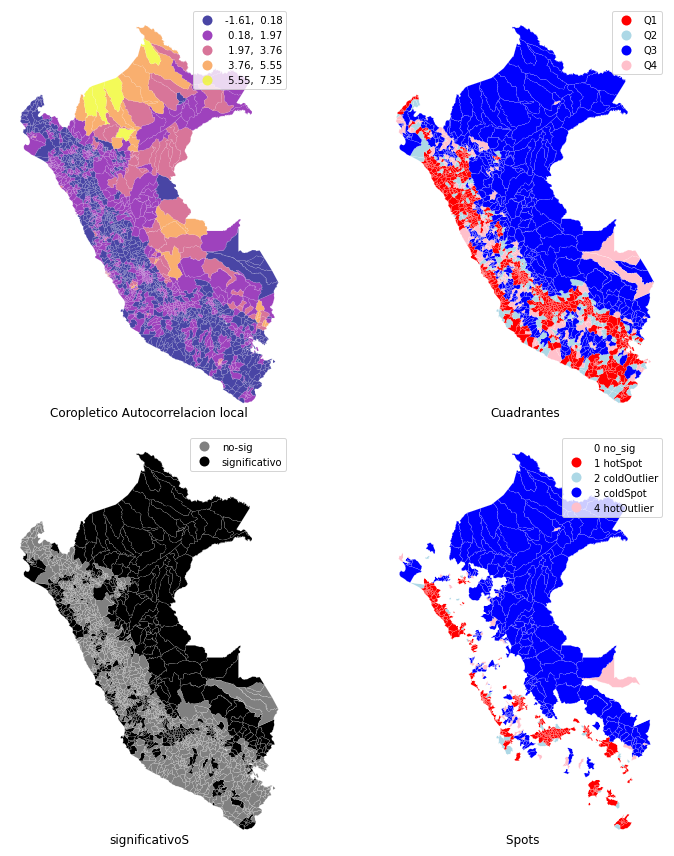

In [92]:
# 4 graficas
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# COROPLETICO DEL LISA #
ax = axs[0]
selecDisMap.plot(column='lisaNBI', 
                 cmap='plasma', 
                 scheme='equal_interval',
                 k=5,
                 edgecolor='white',
                 linewidth=0.1, 
                 alpha=0.75,
                 legend=True, 
                 ax=ax)

# CUADRANTES #
ax = axs[1]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
selecDisMap.plot(column='CuadrantesNBI', 
                 categorical=True,
                 cmap=hmap,
                 linewidth=0.1, 
                 ax=ax,
                 edgecolor='white',
                 legend=True)

# LISA SIGNIFICATIVO #

ax = axs[2]
hmap = colors.ListedColormap(['grey','black'])
selecDisMap.plot(column='SigNBI',
                 categorical=True,
                 cmap=hmap, linewidth=0.1, ax=ax,
                 edgecolor='white', legend=True)

                       
# LISA SPOTS #
ax = axs[3]

hmap = colors.ListedColormap([ 'white', 'red', 'lightblue', 'blue', 'pink'])
selecDisMap.plot(column='SpotsNBI',
                 categorical=True,
                 cmap=hmap,
                 linewidth=0.1, ax=ax,
                 edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Coropletico Autocorrelacion local', 
                  'Cuadrantes', 
                  'significativoS', 
                  'Spots '][i], y=0)

f.tight_layout()

plt.show()

In [ ]:
# guardando data
selecDisMap.to_file("selecDisMap.gpkg", layer='DISTRITO', driver="GPKG")

### Enfocandonos en los ZG

In [93]:
datadis.Zona.value_counts()

X      1741
ZG       77
ZNG      56
Name: Zona, dtype: int64

In [94]:
# qué relacion es más evidente?
pd.crosstab(selecDisMap.Zona, 
            selecDisMap.SpotsNBI,
            dropna=False)

SpotsNBI,0 no_sig,1 hotSpot,2 coldOutlier,3 coldSpot,4 hotOutlier
Zona,,,,,
X,1091,350,30,218,52
ZG,22,0,0,53,2
ZNG,2,54,0,0,0


Text(-1.5, -3.5, 'coldSpot')

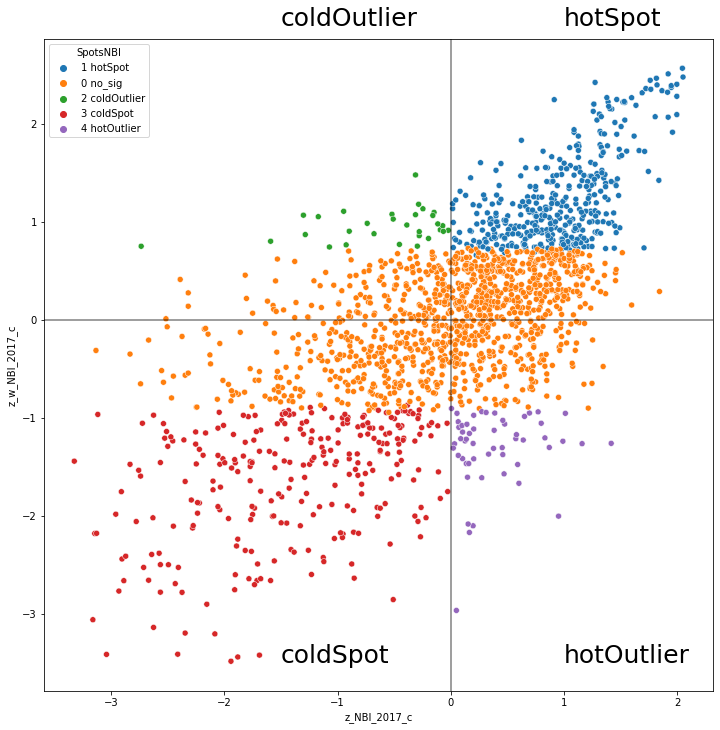

In [95]:
# x y xlag , por cuadrantes
f, ax = plt.subplots(1, figsize=(12, 12))
seaborn.scatterplot(data=selecDisMap, x='z_NBI_2017_c', y='z_w_NBI_2017_c',hue="SpotsNBI",ax=ax)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1, 3, "hotSpot", fontsize=25)
plt.text(1, -3.5, "hotOutlier", fontsize=25)
plt.text(-1.5, 3, "coldOutlier", fontsize=25)
plt.text(-1.5, -3.5, "coldSpot", fontsize=25)

<AxesSubplot:xlabel='z_NBI_2017_c', ylabel='z_w_NBI_2017_c'>

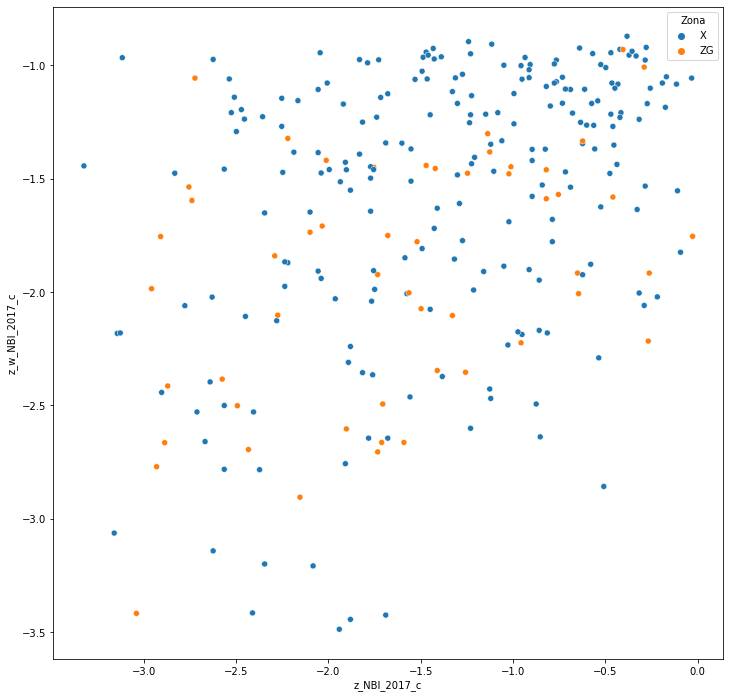

In [96]:
# los distritos donde hay mas probabilidad de ser ZG segun lo anterior
f, ax = plt.subplots(1, figsize=(12, 12))
seaborn.scatterplot(data=selecDisMap[selecDisMap.SpotsNBI=='3 coldSpot'], 
                    x='z_NBI_2017_c', 
                    y='z_w_NBI_2017_c',ax=ax,
                    hue="Zona")

# graficando vecindario más probable

In [97]:
# preparando puntos (proyectados)
selecDisPoints=gpd.GeoDataFrame(selecDisMap[selecDisMap.SpotsNBI=='3 coldSpot'],
                                geometry=gpd.points_from_xy(selecDisMap[selecDisMap.SpotsNBI=='3 coldSpot'].Longitud,
                                                          selecDisMap[selecDisMap.SpotsNBI=='3 coldSpot'].Latitud))

In [98]:
selecDisPoints.crs

In [99]:
# asegurando que comparten misma proyección
selecDisPoints.crs=selecDisMap.crs
selecDisPoints.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### ZG y vecinos

<AxesSubplot:>

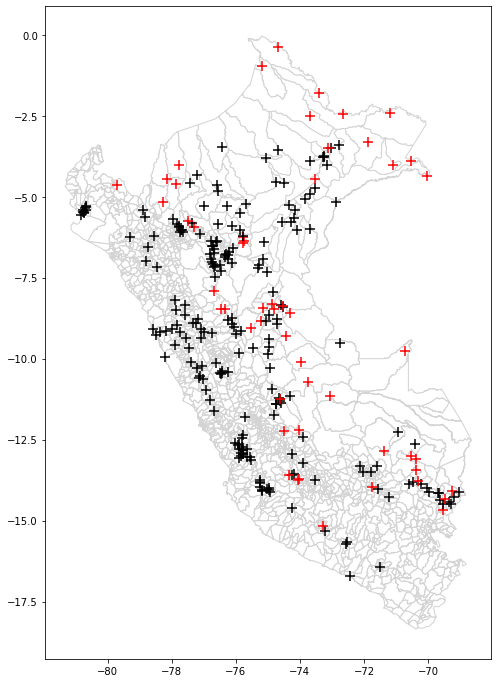

In [100]:
f, ax = plt.subplots(1, figsize=(12, 12))
hmap = colors.ListedColormap([ 'black', 'red'])
base=selecDisMap.plot(ax=ax,color='white',
                 edgecolor='lightgrey')
selecDisPoints.plot(column='Zona',
                    categorical=True,
                    ax=base, marker='+', markersize=100,
                    cmap=hmap)

In [101]:
selecDisPoints.to_file("selecDisPoints.gpkg", layer='DISTRITO', driver="GPKG")

In [102]:
selecDisPoints

,DISTRITO,geometry,provDist,DEPARTAMENTO,PROVINCIA,Zona,Latitud,Longitud,cobertura_cell,no_cobertura_cell,...,Pobreza,No_Pobreza,Ing_fam_p_cap_N,w_NBI_2017_c,z_NBI_2017_c,z_w_NBI_2017_c,lisaNBI,CuadrantesNBI,SigNBI,SpotsNBI
140,CABANACONDE,POINT (-72.57280 -15.71310),CAYLLOMA+CABANACONDE,AREQUIPA,CAYLLOMA,X,-15.7131,-72.5728,24.390244,75.609756,...,33.874310,66.125690,25.737905,46.3250,-0.415730,-1.209305,0.342671,Q3,significativo,3 coldSpot
159,MADRIGAL,POINT (-72.42750 -16.71640),CAYLLOMA+MADRIGAL,AREQUIPA,CAYLLOMA,X,-16.7164,-72.4275,17.241379,82.758621,...,29.567210,70.432790,21.170526,49.6750,-0.372007,-0.955639,0.238521,Q3,significativo,3 coldSpot
163,CHICHAS,POINT (-73.22140 -15.32110),CONDESUYOS+CHICHAS,AREQUIPA,CONDESUYOS,X,-15.3211,-73.2214,4.166667,95.833333,...,38.946115,61.053885,45.253952,50.4625,-1.240995,-0.896008,0.742283,Q3,significativo,3 coldSpot
244,CAYLLOMA,POINT (-71.50830 -16.42330),CAYLLOMA+CAYLLOMA,AREQUIPA,CAYLLOMA,X,-16.4233,-71.5083,12.048193,87.951807,...,40.761881,59.238119,44.910257,48.0500,-0.191651,-1.078686,0.139903,Q3,significativo,3 coldSpot
260,HUAYNACOTAS,POINT (-72.52470 -15.65470),LA UNION+HUAYNACOTAS,AREQUIPA,LA UNION,X,-15.6547,-72.5247,8.910891,91.089109,...,42.179079,57.820921,16.492310,49.3875,-0.765511,-0.977408,0.502855,Q3,significativo,3 coldSpot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,LA MORADA,POINT (-76.24970 -8.79330),MARANON+LA MORADA,HUANUCO,MARAÑON,X,-8.7933,-76.2497,12.500000,87.500000,...,29.275970,70.724030,37.229128,44.2125,-1.552519,-1.369266,1.458930,Q3,significativo,3 coldSpot
1811,PUCAYACU,POINT (-76.12530 -8.74920),LEONCIO PRADO+PUCAYACU,HUANUCO,LEONCIO PRADO,X,-8.7492,-76.1253,14.285714,85.714286,...,23.720490,76.279510,25.280673,43.0125,-1.754736,-1.460131,1.764040,Q3,significativo,3 coldSpot
1813,PUEBLO NUEVO,POINT (-76.07140 -9.00890),LEONCIO PRADO+PUEBLO NUEVO,HUANUCO,LEONCIO PRADO,X,-9.0089,-76.0714,34.615385,65.384615,...,18.991424,81.008576,32.401327,47.4375,-0.995055,-1.125065,0.759686,Q3,significativo,3 coldSpot
1815,ROBLE,POINT (-74.49000 -12.21690),TAYACAJA+ROBLE,HUANCAVELICA,TAYACAJA,ZG,-12.2169,-74.4900,2.631579,97.368421,...,53.720672,46.279328,31.767821,44.6750,-0.623412,-1.334245,0.570074,Q3,significativo,3 coldSpot
